### GPT-2 Model

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import pandas as pd
import evaluate

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to("cuda" if torch.cuda.is_available() else "cpu")

# Load test dataset
test_data = pd.read_csv("/content/drive/MyDrive/TST/test.csv")
# test_data = df[:500]

# Load Evaluation Metrics
bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")
bertscore_metric = evaluate.load("bertscore")

# Function to generate formal sentences using GPT-2
def generate_formal_sentence(informal_text):
    input_text = "informal: " + informal_text + " formal: "
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = model.generate(input_ids,
                                    max_length=128,
                                    num_beams=5,
                                    repetition_penalty=2.0,
                                    pad_token_id=tokenizer.eos_token_id)  # Handle padding

    return tokenizer.decode(output_ids[0], skip_special_tokens=True).replace(input_text, "").strip()

# Function to calculate Perplexity (Lower = Better Fluency)
def calculate_perplexity(sentence):
    inputs = tokenizer(sentence, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        loss = model(inputs, labels=inputs).loss
    return torch.exp(loss).item()

# Evaluate model
correct_predictions = 0
total_samples = len(test_data)
predictions, references, perplexities = [], [], []

for i, row in test_data.iterrows():
    informal = row["informal"]
    formal = row["formal"]

    predicted_formal = generate_formal_sentence(informal)

    predictions.append(predicted_formal)
    references.append([formal])  # BLEU expects a list of references
    perplexities.append(calculate_perplexity(predicted_formal))  # Fluency score

    if predicted_formal.strip() == formal.strip():
        correct_predictions += 1

# Compute Evaluation Metrics
accuracy = correct_predictions / total_samples * 100
bleu_score = bleu_metric.compute(predictions=predictions, references=references)["score"]
rouge_scores = rouge_metric.compute(predictions=predictions, references=references)
bertscore_results = bertscore_metric.compute(predictions=predictions, references=references, lang="hi")
avg_perplexity = sum(perplexities) / len(perplexities)  # Average perplexity

# Print Results
print("\n=====GPT-2 Model Evaluation Results =====")
print(f"🔹 BLEU Score: {bleu_score:.2f}")
print(f"🔹 BERTScore Precision: {sum(bertscore_results['precision']) / len(bertscore_results['precision']):.2f}")
print(f"🔹 BERTScore Recall: {sum(bertscore_results['recall']) / len(bertscore_results['recall']):.2f}")
print(f"🔹 BERTScore F1: {sum(bertscore_results['f1']) / len(bertscore_results['f1']):.2f}")
print(f"🔹 Perplexity (Lower = Better Fluency): {avg_perplexity:.2f}")


Using device: cuda

=====GPT-2 Model Evaluation Results =====
🔹 BLEU Score: 0.26
🔹 BERTScore Precision: 0.58
🔹 BERTScore Recall: 0.62
🔹 BERTScore F1: 0.60
🔹 Perplexity (Lower = Better Fluency): 3.13


### mBART

In [ ]:
from transformers import MBartForConditionalGeneration, MBartTokenizer
import pandas as pd
import torch
import math
from tqdm import tqdm
import evaluate

# Load metrics
bleu = evaluate.load("sacrebleu")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Load dataset
test_data = pd.read_csv("/kaggle/input/dataset/test.csv")  # update as needed

# Load mBART model and tokenizer
model_name = "facebook/mbart-large-50-many-to-many-mmt"
tokenizer = MBartTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Set language codes
tokenizer.src_lang = "hi_IN"
tokenizer.tgt_lang = "hi_IN"
target_lang = "hi_IN"

# Function to generate formal sentence
def generate_formal_sentence(informal_text, max_new_tokens=60):
    tokenizer.src_lang = "hi_IN"
    inputs = tokenizer(informal_text, return_tensors="pt").to(model.device)
    generated_tokens = model.generate(
        **inputs,
        forced_bos_token_id=tokenizer.lang_code_to_id[target_lang],
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=50,
        top_p=0.95
    )
    return tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

def compute_perplexity(source_text, target_text):
    tokenizer.src_lang = "hi_IN"
    tokenizer.tgt_lang = "hi_IN"

    # Encode input and target separately
    input_encodings = tokenizer(source_text, return_tensors="pt").to(model.device)
    target_encodings = tokenizer(target_text, return_tensors="pt").to(model.device)

    labels = target_encodings["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100  # ignore padding tokens in loss

    with torch.no_grad():
        outputs = model(**input_encodings, labels=labels)
        loss = outputs.loss.item()
        perplexity = math.exp(loss)
        return perplexity


# Inference loop
predictions = []
references = []
perplexities = []

for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
    informal = row["informal"]
    formal = row["formal"]

    pred = generate_formal_sentence(informal)
    predictions.append(pred)
    references.append([formal])  # BLEU needs list of refs

    ppl = compute_perplexity(informal, formal)
    perplexities.append(ppl)

# Compute scores
bleu_score = bleu.compute(predictions=predictions, references=references)["score"]
rouge_scores = rouge.compute(predictions=predictions, references=[ref[0] for ref in references])
bertscore_results = bertscore.compute(predictions=predictions, references=[ref[0] for ref in references], lang="hi")
avg_ppl = sum(perplexities) / len(perplexities)

# Print Results
print("\n===== mBART Evaluation Results =====")
print(f"🔹 BLEU Score: {bleu_score:.2f}")
print(f"🔹 ROUGE Scores: {rouge_scores}")
print(f"🔹 BERTScore Precision: {sum(bertscore_results['precision']) / len(bertscore_results['precision']):.2f}")
print(f"🔹 BERTScore Recall: {sum(bertscore_results['recall']) / len(bertscore_results['recall']):.2f}")
print(f"🔹 BERTScore F1: {sum(bertscore_results['f1']) / len(bertscore_results['f1']):.2f}")
print(f"🔹 Perplexity Score: {avg_ppl:.2f}")


===== mBART Evaluation Results =====
🔹 BLEU Score: 8.91
🔹 ROUGE Scores: {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
🔹 BERTScore Precision: 0.80
🔹 BERTScore Recall: 0.74
🔹 BERTScore F1: 0.77
🔹 Perplexity Score: 1507.31


### IndicGPT

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import pandas as pd
import evaluate

# Model name (public access)
model_name = "aashay96/indic-gpt"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

def generate_formal_sentence(informal_text, max_new_tokens=60):
    prompt = f"informal: {informal_text}\nformal:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            pad_token_id=tokenizer.eos_token_id  # ✅ Fixes warning
        )
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return result.split("formal:")[-1].strip()

# Load test data
test_data = pd.read_csv("/kaggle/input/dataset/test.csv")  # Update path if needed

# Load evaluation metrics
bleu = evaluate.load("sacrebleu")
rouge = evaluate.load("rouge")
bertscore = evaluate.load("bertscore")

# Store predictions and references
predictions = []
references = []

for _, row in test_data.iterrows():
    informal = row["informal"]
    formal = row["formal"]

    prediction = generate_formal_sentence(informal)
    predictions.append(prediction)
    references.append([formal])

from tqdm import tqdm

def compute_perplexity(input_text, target_text):
    # Prepare the full input text (prompt + expected formal output)
    full_input = f"informal: {input_text}\nformal: {target_text}"
    inputs = tokenizer(full_input, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss.item()
        return math.exp(loss)  # Perplexity = exp(loss)

# Compute average perplexity
perplexities = []
for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
    informal = row["informal"]
    formal = row["formal"]
    ppl = compute_perplexity(informal, formal)
    perplexities.append(ppl)

avg_ppl = sum(perplexities) / len(perplexities)

# Compute evaluation scores
bleu_score = bleu.compute(predictions=predictions, references=references)["score"]
rouge_scores = rouge.compute(predictions=predictions, references=references)
bertscore_results = bertscore.compute(predictions=predictions, references=[ref[0] for ref in references], lang="hi")

# Display results
print("\n===== IndicGPT Evaluation Results =====")
print(f"🔹 BLEU Score: {bleu_score:.2f}")
print(f"🔹 ROUGE Scores: {rouge_scores}")
print(f"🔹 BERTScore Precision: {sum(bertscore_results['precision']) / len(bertscore_results['precision']):.2f}")
print(f"🔹 BERTScore Recall: {sum(bertscore_results['recall']) / len(bertscore_results['recall']):.2f}")
print(f"🔹 BERTScore F1: {sum(bertscore_results['f1']) / len(bertscore_results['f1']):.2f}")


===== IndicGPT Evaluation Results =====
🔹 BLEU Score: 0.02
🔹 ROUGE Scores: {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}
🔹 BERTScore Precision: 0.62
🔹 BERTScore Recall: 0.65
🔹 BERTScore F1: 0.63
🔹 Perplexity Score: 41.77


## All models performance evaluation values

In [21]:
from tabulate import tabulate
import pandas as pd

# Data for the table
data = {
    "Model": ["mT5", "IndicBART", "Ensemble Model", "GPT-2", "IndicGPT", "mBART"],
    "BLEU Score": [23.31, 17.84, 21.25, 0.26, 20.01, 8.91],
    "BERTscore F1": [0.85, 0.81, 0.84, 0.60, 0.63, 0.77],
    "BERTscore Precision": [0.85, 0.82, 0.84, 0.58, 0.62, 0.80],
    "BERTscore Recall": [0.85, 0.81, 0.84, 0.62, 0.65, 0.74],
    "Perplexity": [8.25, 5.36, 6.20, 3.13, 41.77, 15.07]
}

# Create DataFrame
df = pd.DataFrame(data)

# Print the table with borders
print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))


+----------------+--------------+----------------+-----------------------+--------------------+--------------+
| Model          |   BLEU Score |   BERTscore F1 |   BERTscore Precision |   BERTscore Recall |   Perplexity |
+================+==============+================+=======================+====================+==============+
| mT5            |        23.31 |           0.85 |                  0.85 |               0.85 |         8.25 |
+----------------+--------------+----------------+-----------------------+--------------------+--------------+
| IndicBART      |        17.84 |           0.81 |                  0.82 |               0.81 |         5.36 |
+----------------+--------------+----------------+-----------------------+--------------------+--------------+
| Ensemble Model |        21.25 |           0.84 |                  0.84 |               0.84 |         6.2  |
+----------------+--------------+----------------+-----------------------+--------------------+--------------+
|

## Performance Visualisation

### BLEU Score Comparison

<ipython-input-19-db9473d29a61>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="BLEU Score", data=df, palette="viridis")


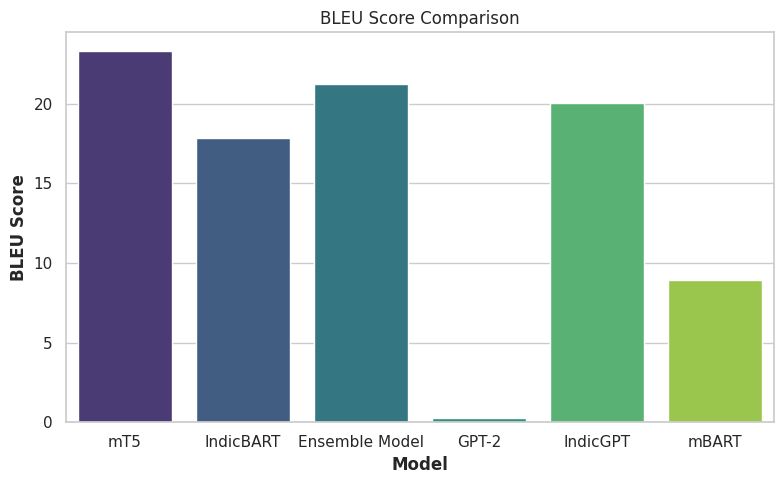

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the table
data = {
    "Model": ["mT5", "IndicBART", "Ensemble Model", "GPT-2", "IndicGPT", "mBART"],
    "BLEU Score": [23.31, 17.84, 21.25, 0.26, 20.01, 8.91]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Plot BLEU Score
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="BLEU Score", data=df, palette="viridis")
plt.title("BLEU Score Comparison")
plt.xlabel("Model", fontsize=12, fontweight='bold')
plt.ylabel("BLEU Score", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


### BERTscore F1 Comparison

<ipython-input-18-951d6b80bed0>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="BERTscore F1", data=df, palette="viridis")


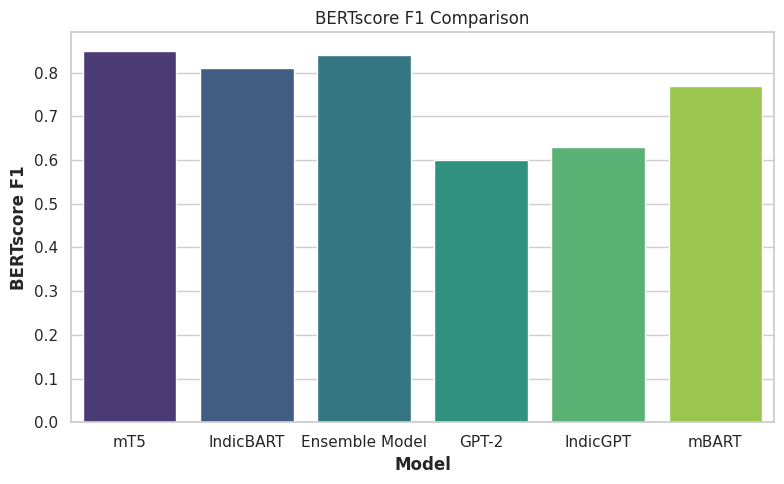

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the table
data = {
    "Model": ["mT5", "IndicBART", "Ensemble Model", "GPT-2", "IndicGPT", "mBART"],
    "BERTscore F1": [0.85, 0.81, 0.84, 0.60, 0.63, 0.77]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Plot BERTscore F1
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="BERTscore F1", data=df, palette="viridis")
plt.title("BERTscore F1 Comparison")
plt.xlabel("Model", fontsize=12, fontweight='bold')
plt.ylabel("BERTscore F1", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


### BERTscore Precision Comparison

<ipython-input-17-11f4eae2e78f>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="BERTscore Precision", data=df, palette="viridis")


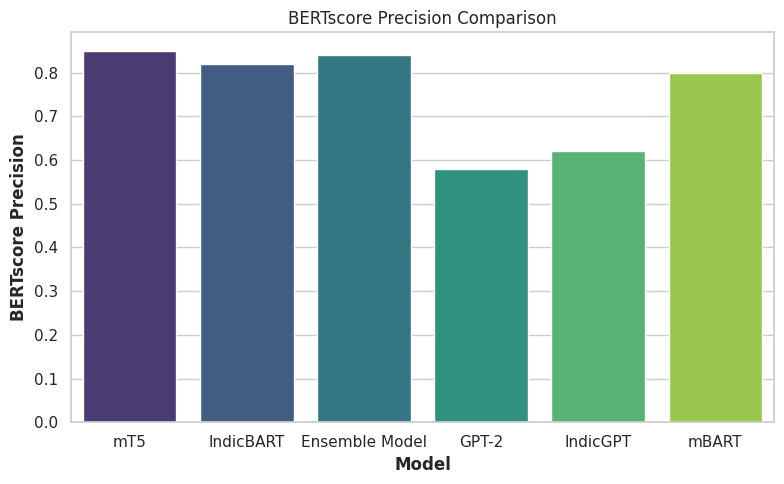

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the table
data = {
    "Model": ["mT5", "IndicBART", "Ensemble Model", "GPT-2", "IndicGPT", "mBART"],
    "BERTscore Precision": [0.85, 0.82, 0.84, 0.58, 0.62, 0.80]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Plot BERTscore Precision
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="BERTscore Precision", data=df, palette="viridis")
plt.title("BERTscore Precision Comparison")
plt.xlabel("Model", fontsize=12, fontweight='bold')
plt.ylabel("BERTscore Precision", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


### BERTscore Recall Comparison

<ipython-input-16-8d34794786a8>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="BERTscore Recall", data=df, palette="viridis")


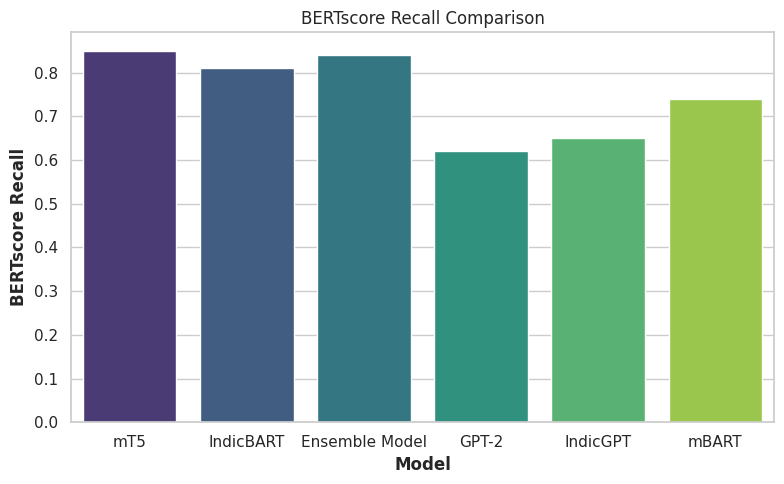

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the table
data = {
    "Model": ["mT5", "IndicBART", "Ensemble Model", "GPT-2", "IndicGPT", "mBART"],
    "BERTscore Recall": [0.85, 0.81, 0.84, 0.62, 0.65, 0.74]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Plot BERTscore Recall
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="BERTscore Recall", data=df, palette="viridis")
plt.title("BERTscore Recall Comparison")
plt.xlabel("Model", fontsize=12, fontweight='bold')
plt.ylabel("BERTscore Recall", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


### Perplexity Comparison

<ipython-input-15-42fe6cc43254>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Perplexity", data=df, palette="viridis")


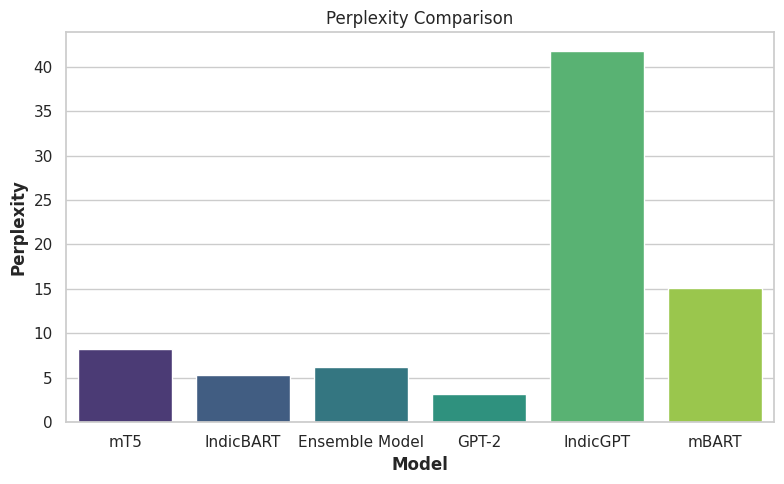

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the table
data = {
    "Model": ["mT5", "IndicBART", "Ensemble Model", "GPT-2", "IndicGPT", "mBART"],
    "Perplexity": [8.25, 5.36, 6.20, 3.13, 41.77, 15.07]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Plot Perplexity
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Perplexity", data=df, palette="viridis")
plt.title("Perplexity Comparison")
plt.xlabel("Model", fontsize=12, fontweight='bold')
plt.ylabel("Perplexity", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


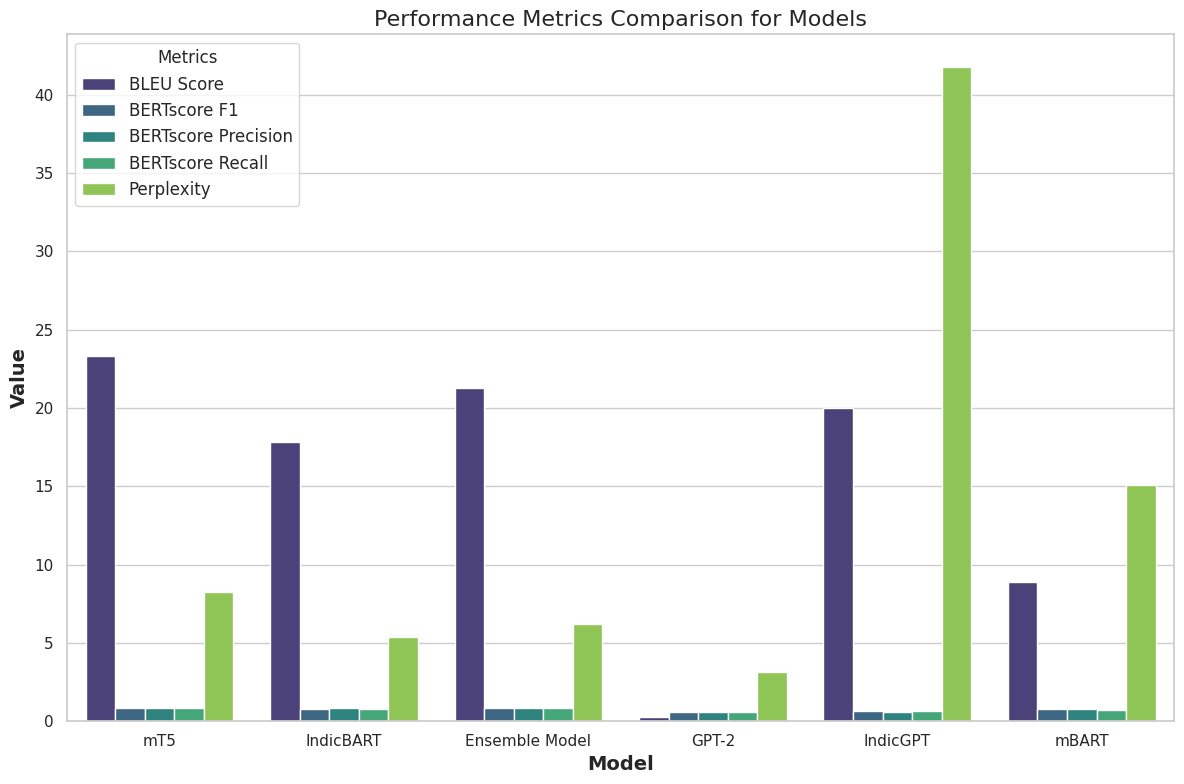

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the table
data = {
    "Model": ["mT5", "IndicBART", "Ensemble Model", "GPT-2", "IndicGPT", "mBART"],
    "BLEU Score": [23.31, 17.84, 21.25, 0.26, 20.01, 8.91],
    "BERTscore F1": [0.85, 0.81, 0.84, 0.60, 0.63, 0.77],
    "BERTscore Precision": [0.85, 0.82, 0.84, 0.58, 0.62, 0.80],
    "BERTscore Recall": [0.85, 0.81, 0.84, 0.62, 0.65, 0.74],
    "Perplexity": [8.25, 5.36, 6.20, 3.13, 41.77, 15.07]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Reshape data for a grouped bar chart
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Value", hue="Metric", data=df_melted, palette="viridis")

# Title and labels
plt.title("Performance Metrics Comparison for Models", fontsize=16)
plt.ylabel("Value", fontsize=14, fontweight='bold')
plt.xlabel("Model", fontsize=14, fontweight='bold')
plt.legend(title="Metrics", fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


## Models Vs Performance Values

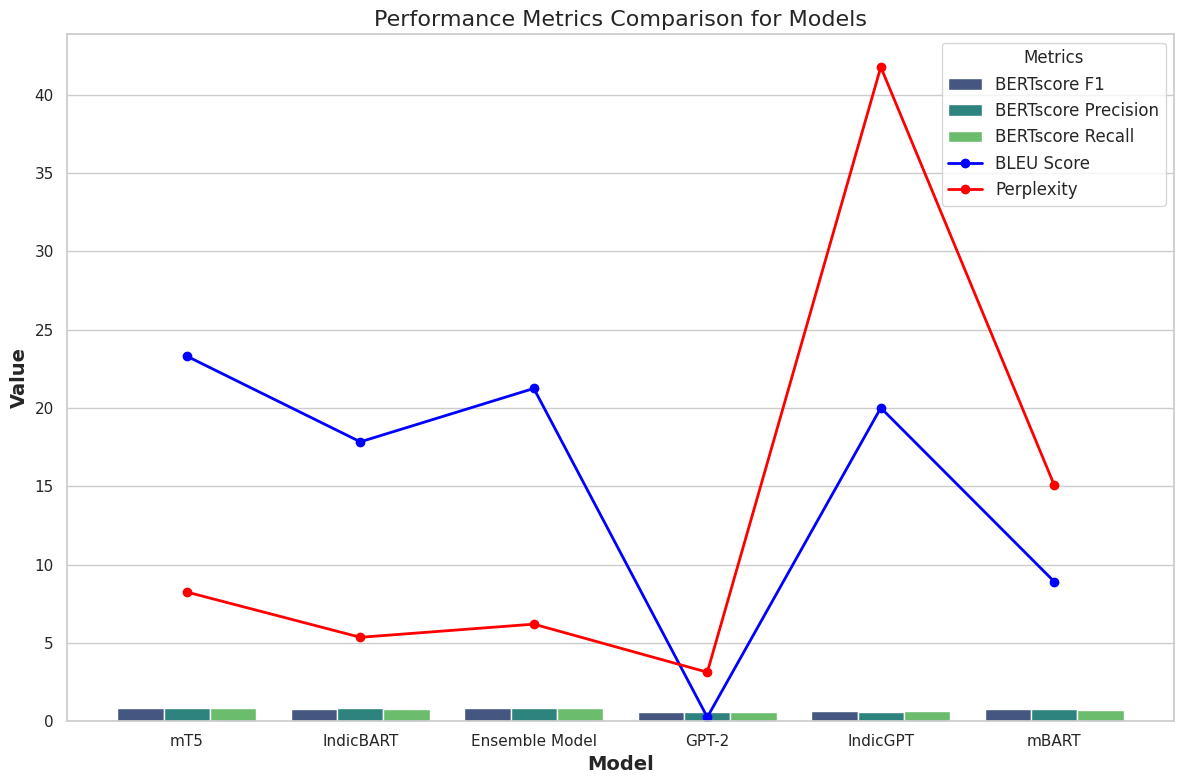

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the table
data = {
    "Model": ["mT5", "IndicBART", "Ensemble Model", "GPT-2", "IndicGPT", "mBART"],
    "BLEU Score": [23.31, 17.84, 21.25, 0.26, 20.01, 8.91],
    "BERTscore F1": [0.85, 0.81, 0.84, 0.60, 0.63, 0.77],
    "BERTscore Precision": [0.85, 0.82, 0.84, 0.58, 0.62, 0.80],
    "BERTscore Recall": [0.85, 0.81, 0.84, 0.62, 0.65, 0.74],
    "Perplexity": [8.25, 5.36, 6.20, 3.13, 41.77, 15.07]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set(style="whitegrid")

# Reshape data for a grouped bar chart (excluding BLEU and Perplexity for the line plot)
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# Set figure size
plt.figure(figsize=(12, 8))

# Plot grouped bar chart for all metrics except BLEU Score and Perplexity
sns.barplot(x="Model", y="Value", hue="Metric", data=df_melted[df_melted["Metric"].isin(["BERTscore F1", "BERTscore Precision", "BERTscore Recall"])], palette="viridis")

# Plot line graphs for BLEU Score and Perplexity
plt.plot(df["Model"], df["BLEU Score"], color='blue', marker='o', label="BLEU Score", linestyle='-', linewidth=2)
plt.plot(df["Model"], df["Perplexity"], color='red', marker='o', label="Perplexity", linestyle='-', linewidth=2)

# Title and labels
plt.title("Performance Metrics Comparison for Models", fontsize=16)
plt.ylabel("Value", fontsize=14, fontweight='bold')
plt.xlabel("Model", fontsize=14, fontweight='bold')

# Add legend
plt.legend(title="Metrics", fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


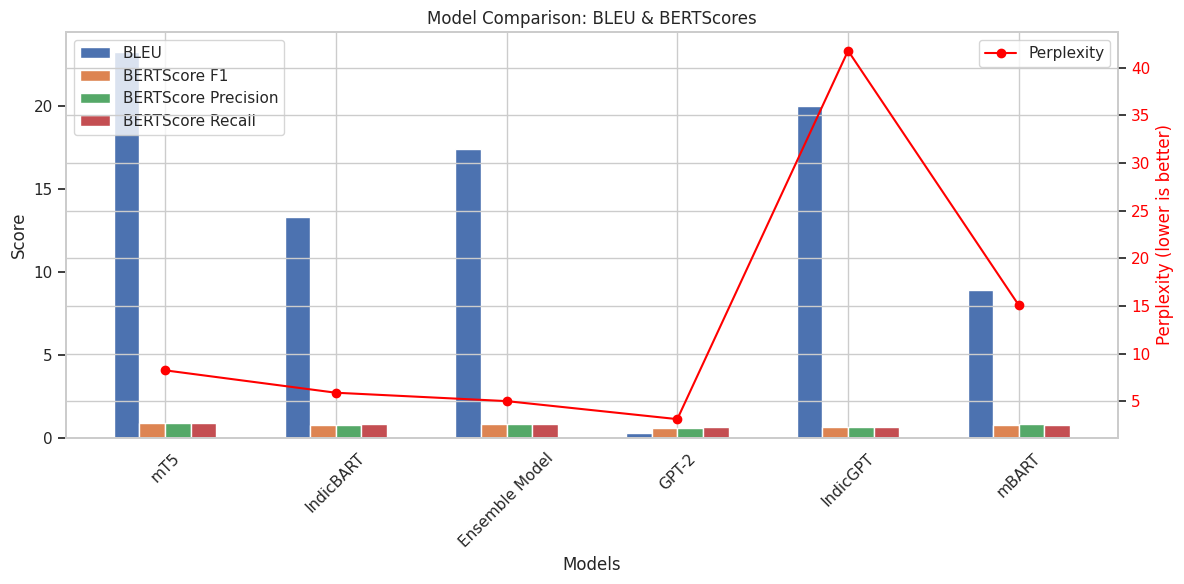

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ["mT5", "IndicBART", "Ensemble Model", "GPT-2", "IndicGPT", "mBART"]

# Metrics
bleu = [23.31, 13.30, 17.45, 0.26, 20.01, 8.91]
bertscore_f1 = [0.85, 0.78, 0.81, 0.60, 0.63, 0.77]
bertscore_precision = [0.85, 0.78, 0.80, 0.58, 0.62, 0.80]
bertscore_recall = [0.85, 0.79, 0.81, 0.62, 0.65, 0.74]
perplexity = [8.25, 5.90, 5.02, 3.13, 41.77, 15.07]

# Bar positions
x = np.arange(len(models))
width = 0.15

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot bars for each metric (except perplexity)
ax1.bar(x - 1.5*width, bleu, width, label='BLEU')
ax1.bar(x - 0.5*width, bertscore_f1, width, label='BERTScore F1')
ax1.bar(x + 0.5*width, bertscore_precision, width, label='BERTScore Precision')
ax1.bar(x + 1.5*width, bertscore_recall, width, label='BERTScore Recall')

# Customizations
ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Model Comparison: BLEU & BERTScores')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.legend(loc='upper left')
ax1.grid(axis='y')

# Show a second axis for perplexity (right y-axis)
ax2 = ax1.twinx()
ax2.plot(x, perplexity, color='red', marker='o', label='Perplexity')
ax2.set_ylabel('Perplexity (lower is better)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
